<a href="https://colab.research.google.com/github/ssabrut/knee-arthritis-detection/blob/main/Annotated_Dataset_for_Knee_Arthritis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files

# # upload your kaggle.json API
# uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
 99% 58.0M/58.3M [00:04<00:00, 19.8MB/s]
100% 58.3M/58.3M [00:04<00:00, 13.5MB/s]


In [5]:
# !unzip annotated-dataset-for-knee-arthritis-detection.zip

Archive:  /content/annotated-dataset-for-knee-arthritis-detection.zip
  inflating: Training/0Normal/NormalG0 (1).png  
  inflating: Training/0Normal/NormalG0 (10).png  
  inflating: Training/0Normal/NormalG0 (100).png  
  inflating: Training/0Normal/NormalG0 (101).png  
  inflating: Training/0Normal/NormalG0 (102).png  
  inflating: Training/0Normal/NormalG0 (103).png  
  inflating: Training/0Normal/NormalG0 (104).png  
  inflating: Training/0Normal/NormalG0 (105).png  
  inflating: Training/0Normal/NormalG0 (106).png  
  inflating: Training/0Normal/NormalG0 (107).png  
  inflating: Training/0Normal/NormalG0 (108).png  
  inflating: Training/0Normal/NormalG0 (109).png  
  inflating: Training/0Normal/NormalG0 (11).png  
  inflating: Training/0Normal/NormalG0 (110).png  
  inflating: Training/0Normal/NormalG0 (111).png  
  inflating: Training/0Normal/NormalG0 (112).png  
  inflating: Training/0Normal/NormalG0 (113).png  
  inflating: Training/0Normal/NormalG0 (114).png  
  inflating: Tra

In [31]:
from PIL import Image

# get sample image for dimension
width, height = Image.open('/content/Training/0Normal/NormalG0 (1).png').size

In [36]:
from tensorflow import keras

images = keras.utils.image_dataset_from_directory('Training', image_size=(height, width))

Found 1650 files belonging to 5 classes.


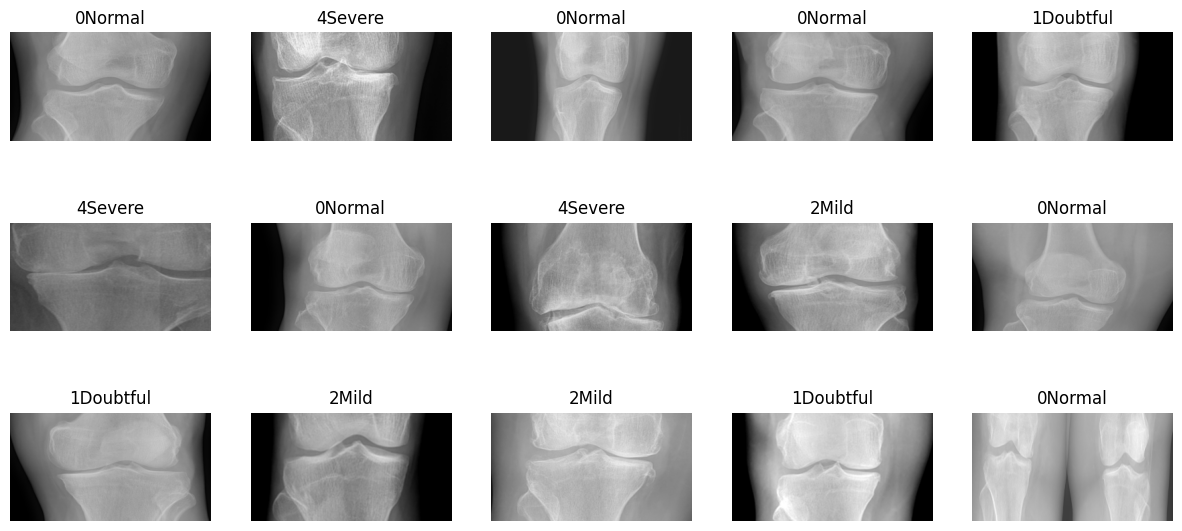

In [44]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 7))
class_names = images.class_names
for image, labels in images.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")